<img src="airbnb.png">




## Context

Since 2008, guests and hosts have used Airbnb to travel in a more unique, personalized way. As part of the Airbnb Inside initiative, this dataset describes the listing activity of homestays in London.

Data can be find here: http://insideairbnb.com/london/

## Approach

This notebook will take the reader through the following steps:

1. Exploratory Analysis of London Airbnb Data
2. Features Selection and Pre-processing
3. Models 
4. Gridsearch (Model Improvement)

Let's try to take a look at the Airbnb listings and see if we can accurately **predict the prices asked** based on the information in the listing:

In [1]:
import sys  

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge,Lasso
from sklearn import metrics
from sklearn import preprocessing, manifold, linear_model, metrics, model_selection, ensemble
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb

%matplotlib inline

In [2]:
train = pd.read_csv("listings.csv")

Let's just keep some columns since there are so many of them:

In [3]:
columns_to_keep = ['id',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'transit',
 'interaction',
 'host_id',
 'host_since',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_verifications',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'city',
 'state',
 'zipcode',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',
 'square_feet',
 'price',
 'security_deposit',
 'cleaning_fee',
 'extra_people',
 'minimum_nights',
 'maximum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'instant_bookable',
 'cancellation_policy',
 'reviews_per_month']

train = train[columns_to_keep]


Let's clean up the data a bit. We will define a function called clean that tidies up some of the columns:

In [4]:
def clean(train):

    train["bedrooms"] = train["bedrooms"].fillna(0.5).astype(float) #these are studios
    train["bathrooms"] = train["bedrooms"].fillna(0) 
    train["summary"] = train["summary"].fillna("")
    train["name"] = train["name"].astype("str")
    train["bedrooms"] = train["bedrooms"].astype("str")

    #replace unpopular types with other 
    popular_types = train["property_type"].value_counts().head(6).index.values
    train.loc[~train.property_type.isin(popular_types), "property_type"] = "Other"

    #make price numeric:
    train["price"] = train["price"].str.replace("[$,]", "").astype("float")
    
    #eliminate very high prices:
    train = train[train["price"] < 600]
    
    return train

In [5]:
train = clean(train)

## 1. Exploratory Data Analysis:

Let's look at the distribution of prices:

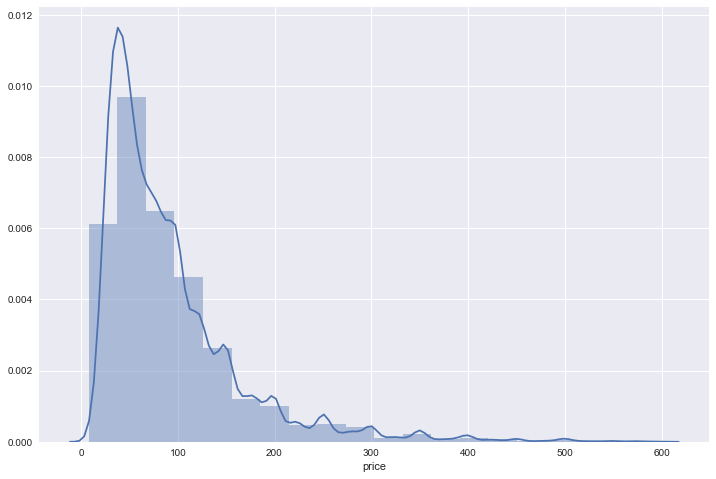

In [6]:
plt.figure(figsize=(12,8))
sns.distplot(train["price"],bins=20)

The price distribution is right-skewed. Let's have a look at mean and standard deviation:

In [7]:
mean = train["price"].mean()
std = train['price'].std()
print 'Mean is {0:.2f} \nStandard deviation is {1:.2f}'.format(mean,std)

Mean is 91.96 
Standard deviation is 72.62


#### Price by neighbourhood:

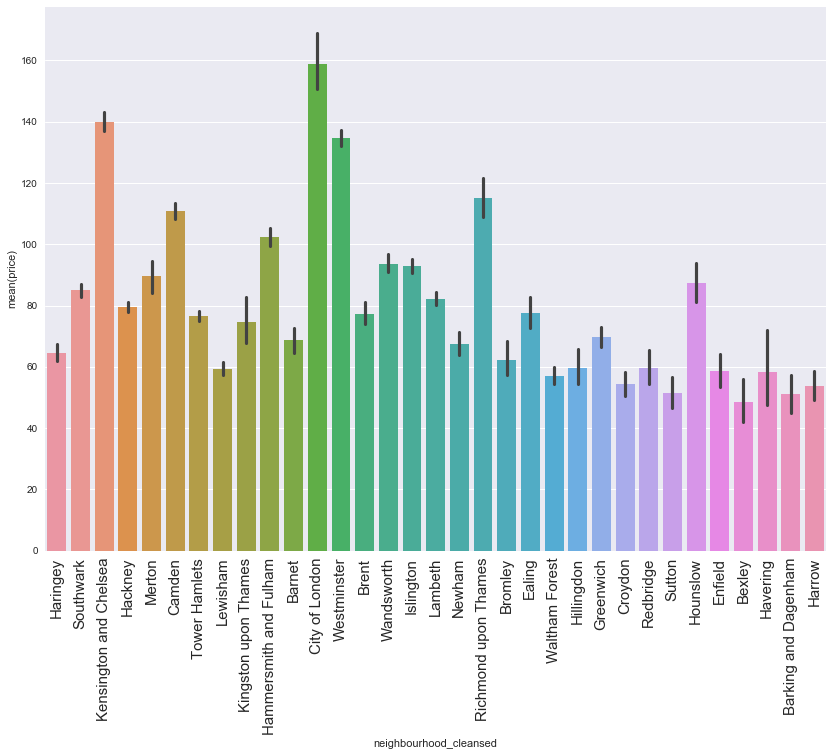

In [8]:
plt.figure(figsize=(14,10))
plt.xticks(rotation=90, size=15)
sns.barplot(x = "neighbourhood_cleansed", y = "price", data = train)

#### Price by room_type:

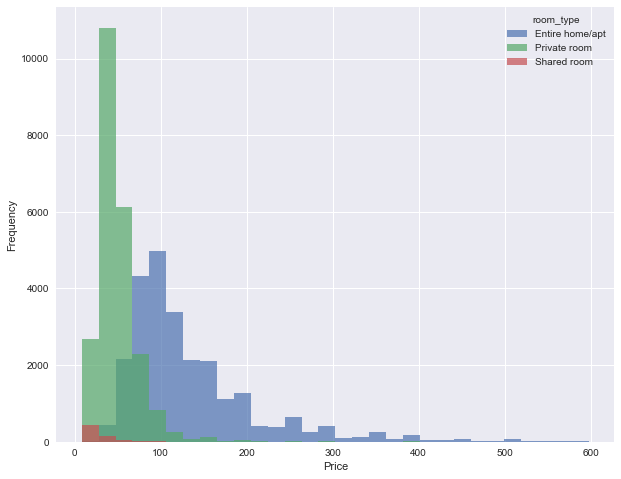

In [9]:
pivot = (train.pivot(index='id',columns = "room_type", values = "price"))
ax = pivot.plot(kind='hist',bins=30,figsize = (10,8),alpha = 0.7)
ax.set_ylabel('Frequency')
ax.set_xlabel('Price')

#### Price by number of bedrooms

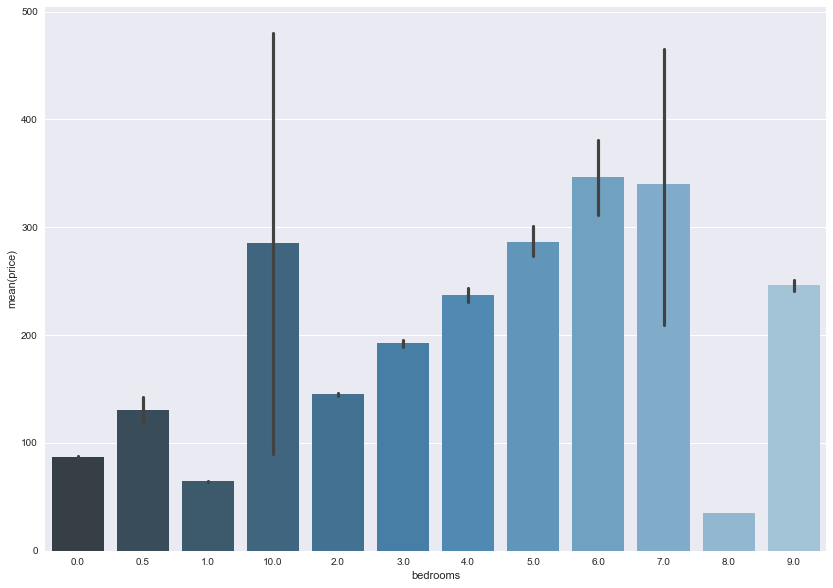

In [10]:
plt.figure(figsize=(14,10))
sns.barplot(x='bedrooms', y='price',data=train, palette="Blues_d",order=list(train.bedrooms.unique()).sort())

##  2. Pre-Processing:

This is a pretty interesting dataset since it contains very "diverse" data classes: looks like we have numerical, categorical and text data.  Let's split them up in two group since text data needs to be processed differently:

In [11]:
y = train["price"]

train_num_cat = train[["neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "latitude", "longitude",
                   "number_of_reviews",
                    "minimum_nights"]]

train_text = train[["name", "summary", "amenities"]]

Now let's one hot encode the categorical data:

In [12]:
X_num = pd.get_dummies(train_num_cat)

In [13]:
train_text.head()

,name,summary,amenities
0,Cosy single w own kitchen/study N8,"A good base for visiting London, with great tr...","{TV,Internet,""Wireless Internet"",Kitchen,""Pets..."
1,Modern luxury maisonette Crouch End,We love the wooden floors throughout and the o...,"{TV,Internet,""Wireless Internet"",""Air conditio..."
2,Spacious 2 Bed apartment near Shad Thames,Spacious apartment with private garden accommo...,"{TV,""Wheelchair accessible"",Kitchen,""Free park..."
3,Fab Family Home - 2 stops to London,A 4 bedroom recently refurbished house in a vi...,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
4,Notting Hill for couples & singles!,We are in the heart of Portobello Rd & Notting...,"{Internet,""Wireless Internet"",Kitchen,""Elevato..."


Amenities are interesting. Let's now encode the amenities using the pd.get_dummies function:

In [14]:
train.amenities = train.amenities.str.replace("[{}]", "")
amenity_dummies = train.amenities.str.get_dummies(sep = ",")

In [15]:
amenity_dummies.head(3)

,"""24-hour check-in""","""Air conditioning""","""Buzzer/wireless intercom""","""Cable TV""","""Carbon monoxide detector""","""Elevator in building""","""Family/kid friendly""","""Fire extinguisher""","""First aid kit""","""Free parking on premises""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,0,0,0,1,0,0,0,1,0,...,0,1,1,1,1,1,0,0,1,0
1,1,1,1,0,1,0,1,0,0,1,...,0,1,1,1,1,1,0,1,1,1
2,0,0,0,0,1,1,1,1,1,1,...,0,1,1,0,1,1,0,1,1,1


## 3. Models:

Now let's build some models! But first let's define some helper functions:

In [32]:
#metric:
def rmse(y_true, y_pred):
    return(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

#make_scorer
from sklearn.metrics import make_scorer
scorer = make_scorer(rmse)

Ok so we have two different matrices: 

In [33]:
(X_num.shape, amenity_dummies.shape)

((49117, 58), (49117, 45))

In [34]:
#this is numeric + amenities:
X = np.hstack((X_num, amenity_dummies))

In [35]:
#We'll use four models: Random Forests, Ridge, Lasso and XGB

forest = ensemble.RandomForestRegressor()
ridge = linear_model.Ridge()
lasso = linear_model.Lasso()
xgb_reg = xgb.XGBRegressor() 

In [36]:
models = [forest,ridge,lasso,xgb_reg]

#We compute the RMSE for each model. We also compute the RMSE for X_num and X_num + amenities as extra features.

models_rmse = [np.mean(cross_val_score(model, X_num, y,cv=3,scoring=scorer)) for model in models]
models_rmse_amenities = [np.mean(cross_val_score(model, X, y,cv=3,scoring=scorer)) for model in models]

In [37]:
# We transform the results in dataframes before plotting them :

models_rmse_df = pd.DataFrame(models_rmse, index = ["forest", "ridge", "lasso", "xgb"], columns = ['Score']).reset_index()
models_rmse_amenities_df = pd.DataFrame(models_rmse_amenities, index = ["forest_am", "ridge_am", "lasso_am", "xgb_am"], \
                                columns = ['Score']).reset_index()

models_mean = pd.DataFrame({'Score': np.mean(train.price)},index=['mean']).reset_index()
models_rmse_all = pd.concat([models_rmse_df,models_rmse_amenities_df,models_mean])
models_rmse_all.sort_values(['Score'],inplace=True)
models_rmse_all.rename(columns={"index": "models"},inplace=True)

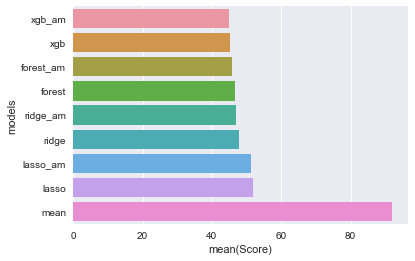

In [38]:
sns.barplot(y='models',x='Score',data=models_rmse_all)

In [39]:
pd.DataFrame(models_rmse_all)

,models,Score
3,xgb_am,44.823996
3,xgb,45.092237
0,forest_am,45.671632
0,forest,46.757121
1,ridge_am,47.063762
1,ridge,47.951064
2,lasso_am,51.403195
2,lasso,51.910314
0,mean,91.964941


It looks like xgboost (score: 44.8) is doing a little bit better than forest, ridge, lasso and of course, mean as a baseline. Adding the amenities helps a bit. Let's see if we can improve our model a little bit further. We will use a GridSearch to find the best XGB parameters.

## 4. XGBoost: GridSearch

In [20]:
#metric
def inv_rmse(y_true, y_pred):
    return(- np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

#make_scorer
from sklearn.metrics import make_scorer
scorer_inv = make_scorer(inv_rmse)

In [22]:
# Tune hyperparameters with grid search

param_grid = {
              'n_estimators': [100,120,140,160,200],
              'learning_rate': [0.1, 0.2, 0.5],
             }
xgb_gs = model_selection.GridSearchCV(xgb_reg, param_grid, cv=3, scoring=scorer_inv)
xgb_gs.fit(X, y)


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, n_estimators=100,
       nthread=-1, objective='reg:linear', seed=0, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 120, 140, 160, 200], 'learning_rate': [0.1, 0.2, 0.5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(inv_rmse), verbose=0)

In [23]:
CV_results = pd.DataFrame(xgb_gs.cv_results_)

43.1261679775
{'n_estimators': 200, 'learning_rate': 0.2}


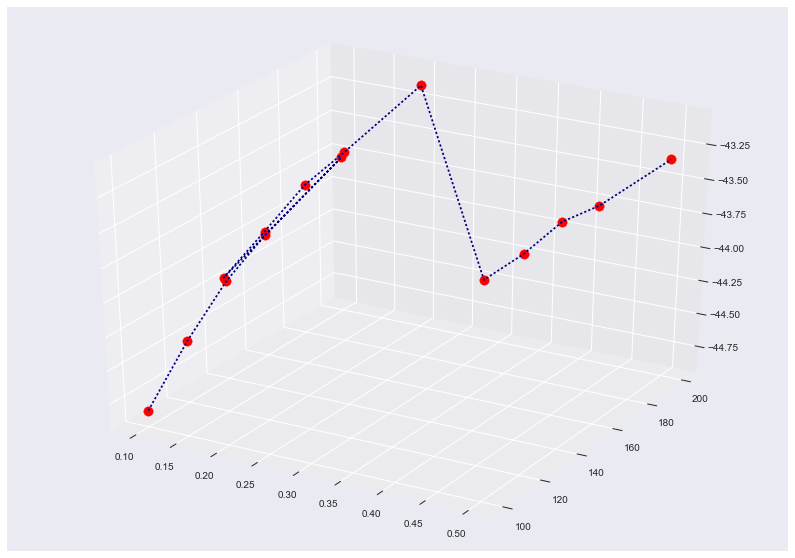

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='3d')

# Make data.
X = CV_results.param_learning_rate
Y = CV_results.param_n_estimators
Z = CV_results.mean_test_score

ax.plot(X, Y, Z, c="navy", ls=":")
ax.scatter(X, Y, Z, c="red",s=90,marker='o',depthshade=False)


print(-xgb_gs.best_score_)
print(xgb_gs.best_params_)
